In [1]:
import os


In [2]:
from __future__ import print_function
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.datasets import fashion_mnist
from keras.datasets import mnist
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
import cv2

Using TensorFlow backend.
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ASUS\Anaconda3

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
Vld_Splt= 0.0909
batch_size = 200
num_classes = 10
epochs = 30

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)\
         .astype('float32')
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).\
         astype('float32')
x_train /= 255
x_test /= 255
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [6]:
print(y_train.shape, '\n',y_test.shape,'\n',
      x_train.shape,'\n', x_test.shape)

(60000, 10) 
 (10000, 10) 
 (60000, 28, 28, 1) 
 (10000, 28, 28, 1)


In [7]:
# the squashing function.
# we use 0.5 in stead of 1 in hinton's paper.
# if 1, the norm of vector will be zoomed out.
# if 0.5, the norm will be zoomed in while original norm is less than 0.5
# and be zoomed out while original norm is greater than 0.5.
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)


class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [8]:
"""one-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_0 = Conv2D(filters= 300, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_0= Dropout(0.1)(x_0)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_0 = Reshape((-1, 300))(x_0)
capsule_0 = Capsule(num_classes, 16, 3, True)(x_0)
output_0 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_0)
model_0 = Model(inputs= input_image, outputs= output_0)

# we use a margin loss
model_0.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_0.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 300)       7800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 300)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 576, 300)          0         
_________________________________________________________________
capsule_1 (Capsule)          (None, 10, 16)            48000     
_________________________________________________________________
lambda_1 (Lambda)    

In [9]:
"""two-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_1 = Conv2D(filters= 30, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_1= Dropout(0.1)(x_1)
x_1 = Conv2D(filters= 60, kernel_size= 5, activation='relu',
             strides= 1)(x_1)
x_1 = Dropout(0.1)(x_1)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_1 = Reshape((-1, 60))(x_1)
capsule_1 = Capsule(num_classes, 16, 3, True)(x_1)
output_1 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_1)
model_1= Model(inputs= input_image, outputs= output_1)

# we use a margin loss
model_1.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_1.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 30)        780       
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 30)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 60)        45060     
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 20, 60)        0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 400, 60)           0         
_________________________________________________________________
capsule_2 (Capsule)          (None, 10, 16)            9600      
__________

In [10]:
"""three-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_2 = Conv2D(filters= 15, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_2= Dropout(0.1)(x_2)
x_2 = Conv2D(filters= 30, kernel_size= 5, activation='relu',
             strides= 1)(x_2)
x_2 = Dropout(0.1)(x_2)
x_2 = Conv2D(filters= 45, kernel_size= 5, activation='relu',
             strides= 1)(x_2)
x_2 = Dropout(0.1)(x_2)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_2 = Reshape((-1, 45))(x_2)
capsule_2 = Capsule(num_classes, 16, 3, True)(x_2)
output_2 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_2)
model_2= Model(inputs= input_image, outputs= output_2)

# we use a margin loss
model_2.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_2.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 15)        390       
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 15)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 30)        11280     
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 20, 30)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 45)        33795     
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 45)        0         
__________

In [11]:
"""four-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_3 = Conv2D(filters= 15, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_3= Dropout(0.1)(x_3)
x_3 = Conv2D(filters= 20 ,kernel_size= 5, activation='relu',
             strides= 1)(x_3)
x_3 = Dropout(0.1)(x_3)
x_3 = Conv2D(filters= 30, kernel_size= 5, activation='relu',
             strides= 1)(x_3)
x_3= Dropout(0.1)(x_3)
x_3 = Conv2D(filters= 30,kernel_size= 5, activation='relu',
             strides= 1)(x_3)
x_3= Dropout(0.1)(x_3)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_3 = Reshape((-1, 30))(x_3)
capsule_3 = Capsule(num_classes, 16, 3, True)(x_3)
output_3 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_3)
model_3= Model(inputs= input_image, outputs= output_3)

# we use a margin loss
model_3.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_3.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 15)        390       
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 24, 15)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 20)        7520      
_________________________________________________________________
dropout_8 (Dropout)          (None, 20, 20, 20)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 30)        15030     
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 30)        0         
__________

In [42]:
"""five-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_4 = Conv2D(filters= 15, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_4= Dropout(0.1)(x_4)
x_4 = Conv2D(filters= 20 ,kernel_size= 5, activation='relu',
             strides= 1)(x_4)
x_4 = Dropout(0.1)(x_4)
x_4 = Conv2D(filters= 20, kernel_size= 5, activation='relu',
             strides= 2)(x_4)
x_4= Dropout(0.1)(x_4)
x_4 = Conv2D(filters= 25,kernel_size= 5, activation='relu',
             padding= 'same')(x_4)
x_4= Dropout(0.1)(x_4)
x_4 = Conv2D(filters= 28,kernel_size= 5, activation='relu',
             strides= 1)(x_4)
x_4= Dropout(0.1)(x_4)

"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_4 = Reshape((-1, 28))(x_4)
capsule_4 = Capsule(num_classes, 16, 3, True)(x_4)
output_4 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_4)
model_4= Model(inputs= input_image, outputs= output_4)

# we use a margin loss
model_4.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_4.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 24, 24, 15)        390       
_________________________________________________________________
dropout_31 (Dropout)         (None, 24, 24, 15)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 20, 20, 20)        7520      
_________________________________________________________________
dropout_32 (Dropout)         (None, 20, 20, 20)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 8, 8, 20)          10020     
_________________________________________________________________
dropout_33 (Dropout)         (None, 8, 8, 20)          0         
__________

In [43]:
"""six-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_5 = Conv2D(filters= 15, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_5= Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 15 ,kernel_size= 5, activation='relu',
             padding= 'same')(x_5)
x_5 = Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 18, kernel_size= 5, activation='relu',
             strides= 2)(x_5)
x_5= Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 20,kernel_size= 5, activation='relu',
             strides= 1)(x_5)
x_5= Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 25,kernel_size= 5, activation='relu',
             padding= 'same')(x_5)
x_5= Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 30,kernel_size= 5, activation='relu',
             strides= 1)(x_5)
x_5= Dropout(0.1)(x_5)

"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_5 = Reshape((-1, 30))(x_5)
capsule_5 = Capsule(num_classes, 16, 3, True)(x_5)
output_5 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_5)
model_5= Model(inputs= input_image, outputs= output_5)

# we use a margin loss
model_5.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_5.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 24, 24, 15)        390       
_________________________________________________________________
dropout_36 (Dropout)         (None, 24, 24, 15)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 24, 24, 15)        5640      
_________________________________________________________________
dropout_37 (Dropout)         (None, 24, 24, 15)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 10, 10, 18)        6768      
_________________________________________________________________
dropout_38 (Dropout)         (None, 10, 10, 18)        0         
__________

In [44]:
"""seven-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_6 = Conv2D(filters= 15, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 15 ,kernel_size= 5, activation='relu',
            padding= 'same')(x_6)
x_6 = Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 15, kernel_size= 5, activation='relu',
              strides= 2)(x_6)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 20,kernel_size= 5, activation='relu',
              padding= 'same')(x_6)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 20,kernel_size= 5, activation='relu',
             padding= 'same')(x_6)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 25,kernel_size= 5, activation='relu',
              strides= 1)(x_6)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 25,kernel_size= 5, activation='relu',
             strides= 1)(x_6)
x_6= Dropout(0.1)(x_6)

"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_6 = Reshape((-1, 25))(x_6)
capsule_6 = Capsule(num_classes, 16, 3, True)(x_6)
output_6 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_6)
model_6= Model(inputs= input_image, outputs= output_6)

# we use a margin loss
model_6.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_6.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 24, 24, 15)        390       
_________________________________________________________________
dropout_42 (Dropout)         (None, 24, 24, 15)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 24, 24, 15)        5640      
_________________________________________________________________
dropout_43 (Dropout)         (None, 24, 24, 15)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 10, 10, 15)        5640      
_________________________________________________________________
dropout_44 (Dropout)         (None, 10, 10, 15)        0         
__________

In [15]:
"""CNN-3-CONV-LAYERS"""
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, \
                         ZeroPadding2D

model_7= Sequential()
model_7.add(Conv2D(filters= 5, kernel_size= (5, 5), padding= 'same', 
                   input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), 
                   activation='relu'))
model_7.add(MaxPooling2D(pool_size=(2,2)))
model_7.add(Conv2D(filters= 18, kernel_size= (5, 5), 
                    padding= 'valid', activation='relu'))
model_7.add(Dropout(0.3))
model_7.add(MaxPooling2D(pool_size=(2,2)))

model_7.add(Flatten())
model_7.add(Dropout(0.4))
model_7.add(Dense(256, activation='relu'))
model_7.add(Dense(num_classes, activation='softmax'))
print(model_7.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 28, 28, 5)         130       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 5)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 10, 10, 18)        2268      
_________________________________________________________________
dropout_29 (Dropout)         (None, 10, 10, 18)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 18)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 450)               0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 450)               0         
__________

In [16]:
"""one-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_0= model_0.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_0= model_0.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 20s 362us/step - loss: 0.3403 - acc: 0.6499 - val_loss: 0.2128 - val_acc: 0.7627
Epoch 2/30
54546/54546 [==============================] - 18s 322us/step - loss: 0.2029 - acc: 0.7607 - val_loss: 0.1889 - val_acc: 0.7816
Epoch 3/30
54546/54546 [==============================] - 18s 326us/step - loss: 0.1843 - acc: 0.7821 - val_loss: 0.1829 - val_acc: 0.7941
Epoch 4/30
54546/54546 [==============================] - 18s 325us/step - loss: 0.1753 - acc: 0.7934 - val_loss: 0.1645 - val_acc: 0.8099
Epoch 5/30
54546/54546 [==============================] - 18s 326us/step - loss: 0.1687 - acc: 0.8015 - val_loss: 0.1665 - val_acc: 0.7968
Epoch 6/30
54546/54546 [==============================] - 17s 320us/step - loss: 0.1619 - acc: 0.8091

In [17]:
"""two-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_1= model_1.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_1= model_1.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 10s 181us/step - loss: 0.3136 - acc: 0.6495 - val_loss: 0.1790 - val_acc: 0.7697
Epoch 2/30
54546/54546 [==============================] - 9s 169us/step - loss: 0.1683 - acc: 0.7776 - val_loss: 0.1491 - val_acc: 0.8022
Epoch 3/30
54546/54546 [==============================] - 9s 170us/step - loss: 0.1482 - acc: 0.8045 - val_loss: 0.1343 - val_acc: 0.8247
Epoch 4/30
54546/54546 [==============================] - 9s 170us/step - loss: 0.1353 - acc: 0.8251 - val_loss: 0.1262 - val_acc: 0.8383
Epoch 5/30
54546/54546 [==============================] - 9s 171us/step - loss: 0.1263 - acc: 0.8380 - val_loss: 0.1178 - val_acc: 0.8458
Epoch 6/30
54546/54546 [==============================] - 9s 170us/step - loss: 0.1207 - acc: 0.8452 - val_loss: 0.1127 - val_acc: 0.8531
Epoch 7/30
54546/54546 [==============================] - 10s 174us/step - loss: 0.1158 - acc

In [18]:
"""three-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_2= model_2.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_2= model_2.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 8s 154us/step - loss: 0.3223 - acc: 0.5960 - val_loss: 0.1684 - val_acc: 0.7719
Epoch 2/30
54546/54546 [==============================] - 8s 138us/step - loss: 0.1583 - acc: 0.7826 - val_loss: 0.1415 - val_acc: 0.7972
Epoch 3/30
54546/54546 [==============================] - 8s 138us/step - loss: 0.1360 - acc: 0.8137 - val_loss: 0.1213 - val_acc: 0.8311
Epoch 4/30
54546/54546 [==============================] - 7s 137us/step - loss: 0.1221 - acc: 0.8355 - val_loss: 0.1104 - val_acc: 0.8480
Epoch 5/30
54546/54546 [==============================] - 7s 135us/step - loss: 0.1133 - acc: 0.8494 - val_loss: 0.1041 - val_acc: 0.8568
Epoch 6/30
54546/54546 [==============================] - 7s 135us/step - loss: 0.1081 - acc: 0.8563 - val_loss: 0.0977 - val_acc: 0.8663
Epoch 7/30
54546/54546 [==============================] - 7s 135us/step - loss: 0.1027 - acc: 

In [19]:
"""four-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_3= model_3.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_3= model_3.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 14s 264us/step - loss: 0.2505 - acc: 0.6685 - val_loss: 0.1456 - val_acc: 0.7928
Epoch 2/30
54546/54546 [==============================] - 13s 247us/step - loss: 0.1399 - acc: 0.8018 - val_loss: 0.1246 - val_acc: 0.8220
Epoch 3/30
54546/54546 [==============================] - 6s 114us/step - loss: 0.1181 - acc: 0.8372 - val_loss: 0.1089 - val_acc: 0.8462
Epoch 4/30
54546/54546 [==============================] - 6s 112us/step - loss: 0.1056 - acc: 0.8569 - val_loss: 0.0953 - val_acc: 0.8691
Epoch 5/30
54546/54546 [==============================] - 6s 110us/step - loss: 0.0968 - acc: 0.8694 - val_loss: 0.0895 - val_acc: 0.8726
Epoch 6/30
54546/54546 [==============================] - 6s 112us/step - loss: 0.0924 - acc: 0.8764 - val_loss: 0.0885 - val_acc: 0.8792
Epoch 7/30
54546/54546 [==============================] - 6s 110us/step - loss: 0.0874 - acc

In [45]:
"""five-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_4= model_4.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_4= model_4.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 6s 107us/step - loss: 0.2366 - acc: 0.6737 - val_loss: 0.1440 - val_acc: 0.7855
Epoch 2/30
54546/54546 [==============================] - 4s 76us/step - loss: 0.1346 - acc: 0.8066 - val_loss: 0.1130 - val_acc: 0.8469
Epoch 3/30
54546/54546 [==============================] - 4s 78us/step - loss: 0.1110 - acc: 0.8446 - val_loss: 0.0953 - val_acc: 0.8632
Epoch 4/30
54546/54546 [==============================] - 5s 86us/step - loss: 0.0998 - acc: 0.8595 - val_loss: 0.0898 - val_acc: 0.8711
Epoch 5/30
54546/54546 [==============================] - 4s 73us/step - loss: 0.0913 - acc: 0.8714 - val_loss: 0.0842 - val_acc: 0.8750
Epoch 6/30
54546/54546 [==============================] - 4s 73us/step - loss: 0.0858 - acc: 0.8797 - val_loss: 0.0783 - val_acc: 0.8843
Epoch 7/30
54546/54546 [==============================] - 4s 75us/step - loss: 0.0815 - acc: 0.8858

In [46]:
"""six-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_5= model_5.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_5= model_5.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 5s 97us/step - loss: 0.2490 - acc: 0.6416 - val_loss: 0.1305 - val_acc: 0.8062
Epoch 2/30
54546/54546 [==============================] - 4s 73us/step - loss: 0.1323 - acc: 0.8134 - val_loss: 0.1141 - val_acc: 0.8377
Epoch 3/30
54546/54546 [==============================] - 4s 73us/step - loss: 0.1115 - acc: 0.8461 - val_loss: 0.0998 - val_acc: 0.8541
Epoch 4/30
54546/54546 [==============================] - 4s 74us/step - loss: 0.0994 - acc: 0.8621 - val_loss: 0.0887 - val_acc: 0.8755
Epoch 5/30
54546/54546 [==============================] - 4s 75us/step - loss: 0.0917 - acc: 0.8734 - val_loss: 0.0817 - val_acc: 0.8841
Epoch 6/30
54546/54546 [==============================] - 4s 76us/step - loss: 0.0862 - acc: 0.8794 - val_loss: 0.0785 - val_acc: 0.8825
Epoch 7/30
54546/54546 [==============================] - 4s 82us/step - loss: 0.0821 - acc: 0.8860 

In [47]:
"""seven-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_6= model_6.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_6= model_6.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 6s 109us/step - loss: 0.3215 - acc: 0.5262 - val_loss: 0.1535 - val_acc: 0.7697
Epoch 2/30
54546/54546 [==============================] - 4s 79us/step - loss: 0.1401 - acc: 0.8001 - val_loss: 0.1076 - val_acc: 0.8443
Epoch 3/30
54546/54546 [==============================] - 4s 82us/step - loss: 0.1119 - acc: 0.8429 - val_loss: 0.0955 - val_acc: 0.8619
Epoch 4/30
54546/54546 [==============================] - 4s 82us/step - loss: 0.0969 - acc: 0.8666 - val_loss: 0.0851 - val_acc: 0.8755
Epoch 5/30
54546/54546 [==============================] - 5s 86us/step - loss: 0.0891 - acc: 0.8747 - val_loss: 0.0810 - val_acc: 0.8876
Epoch 6/30
54546/54546 [==============================] - 5s 83us/step - loss: 0.0840 - acc: 0.8828 - val_loss: 0.0784 - val_acc: 0.8896
Epoch 7/30
54546/54546 [==============================] - 4s 81us/step - loss: 0.0795 - acc: 0.8902

In [23]:
"""CNN-3-CONV-LAYERS"""
model_7.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
train_history_7= model_7.fit(x= x_train, y= y_train, validation_split= Vld_Splt,
                         epochs= epochs, batch_size= batch_size, verbose=1)

Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 3s 53us/step - loss: 0.7183 - acc: 0.7422 - val_loss: 0.4852 - val_acc: 0.8330
Epoch 2/30
54546/54546 [==============================] - 2s 34us/step - loss: 0.4959 - acc: 0.8196 - val_loss: 0.4303 - val_acc: 0.8533
Epoch 3/30
54546/54546 [==============================] - 2s 34us/step - loss: 0.4434 - acc: 0.8382 - val_loss: 0.3831 - val_acc: 0.8640
Epoch 4/30
54546/54546 [==============================] - 2s 33us/step - loss: 0.4143 - acc: 0.8501 - val_loss: 0.3577 - val_acc: 0.8717
Epoch 5/30
54546/54546 [==============================] - 2s 33us/step - loss: 0.3899 - acc: 0.8581 - val_loss: 0.3431 - val_acc: 0.8773
Epoch 6/30
54546/54546 [==============================] - 2s 33us/step - loss: 0.3727 - acc: 0.8638 - val_loss: 0.3249 - val_acc: 0.8794
Epoch 7/30
54546/54546 [==============================] - 2s 33us/step - loss: 0.3576 - acc: 0.8688 - val_loss: 0.3232 - val_acc:

In [24]:
"""one-CONV-LAYERS-THICK"""
scores_0= model_0.evaluate(x_test, y_test)
scores_0[1]

10000/10000 [==============================] - 1s 120us/step


0.8376

In [25]:
"""two-CONV-LAYERS-THICK"""
scores_1= model_1.evaluate(x_test, y_test)
scores_1[1]

10000/10000 [==============================] - 1s 86us/step


0.8931

In [26]:
"""three-CONV-LAYERS-THICK"""
scores_2= model_2.evaluate(x_test, y_test)
scores_2[1]

10000/10000 [==============================] - 1s 79us/step


0.8979

In [48]:
"""four-CONV-LAYERS-THICK"""
scores_3= model_3.evaluate(x_test, y_test)
scores_3[1]

10000/10000 [==============================] - 1s 94us/step


0.9085

In [49]:
"""five-CONV-LAYERS-THICK"""
scores_4= model_4.evaluate(x_test, y_test)
scores_4[1]

10000/10000 [==============================] - 1s 95us/step


0.9114

In [50]:
"""six-CONV-LAYERS-THICK"""
scores_5= model_5.evaluate(x_test, y_test)
scores_5[1]

10000/10000 [==============================] - 1s 98us/step


0.9116

In [51]:
"""seven-CONV-LAYERS-THICK"""
scores_6= model_6.evaluate(x_test, y_test)
scores_6[1]

10000/10000 [==============================] - 1s 101us/step


0.9185

In [52]:
"""CNN"""
scores_7= model_7.evaluate(x_test, y_test)
scores_7[1]

10000/10000 [==============================] - 1s 71us/step


0.9106

In [53]:
import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

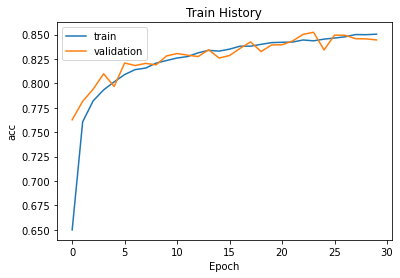

In [54]:
show_train_history(train_history_0, 'acc', 'val_acc')

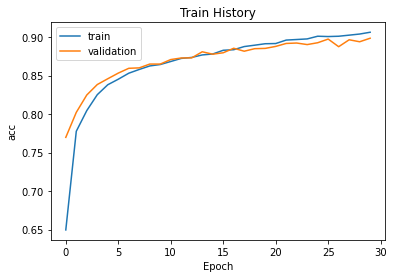

In [55]:
show_train_history(train_history_1, 'acc', 'val_acc')

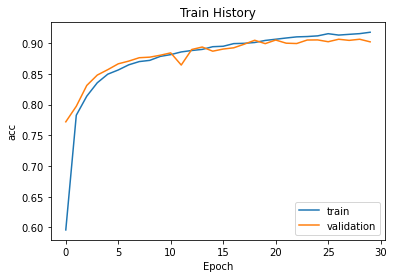

In [56]:
show_train_history(train_history_2, 'acc', 'val_acc')

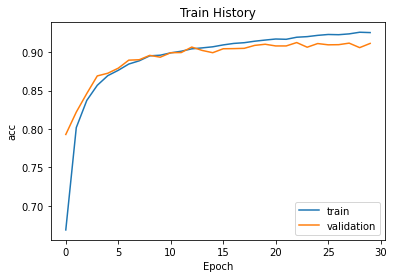

In [57]:
show_train_history(train_history_3, 'acc', 'val_acc')

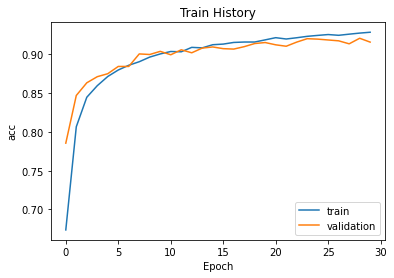

In [58]:
show_train_history(train_history_4, 'acc', 'val_acc')

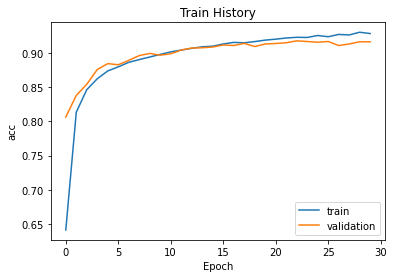

In [59]:
show_train_history(train_history_5, 'acc', 'val_acc')

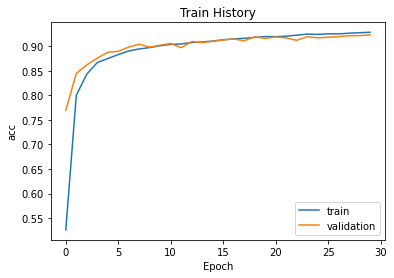

In [60]:
show_train_history(train_history_6, 'acc', 'val_acc')

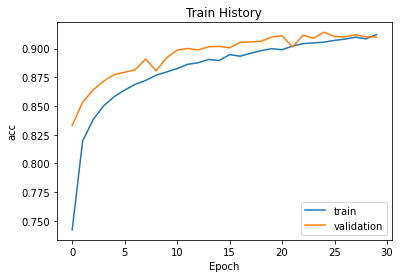

In [61]:
show_train_history(train_history_7, 'acc', 'val_acc')

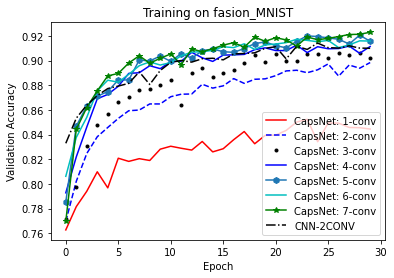

In [62]:
plt.plot(train_history_0.history['val_acc'], 'r-')
plt.plot(train_history_1.history['val_acc'], 'b--')
plt.plot(train_history_2.history['val_acc'], 'k.')
plt.plot(train_history_3.history['val_acc'], 'b-')
plt.plot(train_history_4.history['val_acc'], 'h-')
plt.plot(train_history_5.history['val_acc'], 'c-')
plt.plot(train_history_6.history['val_acc'], 'g*-')
plt.plot(train_history_7.history['val_acc'], 'k-.')
plt.title('Training on fasion_MNIST')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['CapsNet: 1-conv','CapsNet: 2-conv','CapsNet: 3-conv','CapsNet: 4-conv','CapsNet: 5-conv','CapsNet: 6-conv',
           'CapsNet: 7-conv','CNN-2CONV'], loc='best')
plt.show()